### Import libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

### Load data
#### The dataset was downloaded from [insideairbnb](http://insideairbnb.com/get-the-data.html) for the city of Austin, Date Compiled on March 17th, 2020. 
#### Let's import the dataset and take a look at the first few observations.

In [2]:
# import dataset
df = pd.read_csv('data/listings.csv', low_memory=False, index_col='id')
df.head()

listing_url       scrape_id last_scraped  \
id                                                                     
2265  https://www.airbnb.com/rooms/2265  20200317143754   2020-03-17   
5245  https://www.airbnb.com/rooms/5245  20200317143754   2020-03-17   
5456  https://www.airbnb.com/rooms/5456  20200317143754   2020-03-17   
5769  https://www.airbnb.com/rooms/5769  20200317143754   2020-03-17   
6413  https://www.airbnb.com/rooms/6413  20200317143754   2020-03-17   

                                                   name  \
id                                                        
2265   Zen-East in the Heart of Austin (monthly rental)   
5245  Eco friendly, Colorful, Clean, Cozy monthly share   
5456          Walk to 6th, Rainey St and Convention Ctr   
5769                                     NW Austin Room   
6413                      Gem of a Studio near Downtown   

                                                summary  \
id                                                        
2265  Zen East is situated in a vibrant & diverse mu...   
5245  Situated in a vibrant & diverse multicultural ...   
5456  Great central  location for walking to Convent...   
5769                                                NaN   
6413  Great studio apartment, perfect for couples or...   

                                                  space  \
id                                                        
2265  This colorful and clean 1923 house was complet...   
5245  This green, colorful, clean and cozy house was...   
5456  Cute Private Studio apartment located in Willo...   
5769  Looking for a comfortable inexpensive room to ...   
6413  !!!!! SXSW info !!!!! Presently open (again!) ...   

                                            description experiences_offered  \
id                                                                            
2265  Zen East is situated in a vibrant & diverse mu...                none   
5245  Situated in a vibrant & diverse multicultural ...                none   
5456  Great central  location for walking to Convent...                none   
5769  Looking for a comfortable inexpensive room to ...                none   
6413  Great studio apartment, perfect for couples or...                none   

                                  neighborhood_overview  \
id                                                        
2265                                                NaN   
5245                                                NaN   
5456  My neighborhood is ideally located if you want...   
5769  Quiet neighborhood with lots of trees and good...   
6413  Travis Heights is one of the oldest neighborho...   

                                                  notes  ... instant_bookable  \
id                                                       ...                    
2265  A 2013 Genuine Buddy Scooter 125 may be availa...  ...                f   
5245  Please note: A two story studio was built in t...  ...                f   
5456  Parking on street requires a permit.  Permits ...  ...                f   
5769                                                NaN  ...                f   
6413  Our calendar only extends a few months. If you...  ...                t   

     is_business_travel_ready          cancellation_policy  \
id                                                           
2265                        f  strict_14_with_grace_period   
5245                        f  strict_14_with_grace_period   
5456                        f  strict_14_with_grace_period   
5769                        f                     moderate   
6413                        f  strict_14_with_grace_period   

     require_guest_profile_picture  require_guest_phone_verification  \
id                                                                     
2265                             f                                 f   
5245                             f                                 f   
5456                  

In [3]:
# shape
df.shape

(11668, 105)

The Airbnb dataset for Austin, TX consists of 106 features and 11668 observations. We need to look at these features closely and drop the ones that do not help our model to predict the rental prices. 

In [4]:
# specifying max_cols=df.shape[1] so we can look at the columns in df.info()
df.info(max_cols=df.shape[1])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11668 entries, 2265 to 42931550
Data columns (total 105 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   listing_url                                   11668 non-null  object 
 1   scrape_id                                     11668 non-null  int64  
 2   last_scraped                                  11668 non-null  object 
 3   name                                          11668 non-null  object 
 4   summary                                       11244 non-null  object 
 5   space                                         9083 non-null   object 
 6   description                                   11461 non-null  object 
 7   experiences_offered                           11668 non-null  object 
 8   neighborhood_overview                         7937 non-null   object 
 9   notes                                         5553 non

In [5]:
# ordering null columns based on the number of null values in each column
print('Columns with Null values by their count:')
df.isnull().sum().sort_values(ascending=False)[:25]

Columns with Null values by their count:


neighbourhood_group_cleansed    11668
medium_url                      11668
xl_picture_url                  11668
thumbnail_url                   11668
license                         11621
square_feet                     11476
monthly_price                   10931
weekly_price                    10793
notes                            6115
access                           4917
transit                          4370
host_about                       4099
interaction                      3862
house_rules                      3759
neighborhood_overview            3731
host_response_time               3462
host_response_rate               3462
security_deposit                 3100
host_acceptance_rate             2765
review_scores_location           2675
review_scores_value              2674
review_scores_checkin            2670
review_scores_communication      2670
review_scores_accuracy           2669
review_scores_cleanliness        2669
dtype: int64

Using MSNO to look at Misisng Values in 25 columns visually.

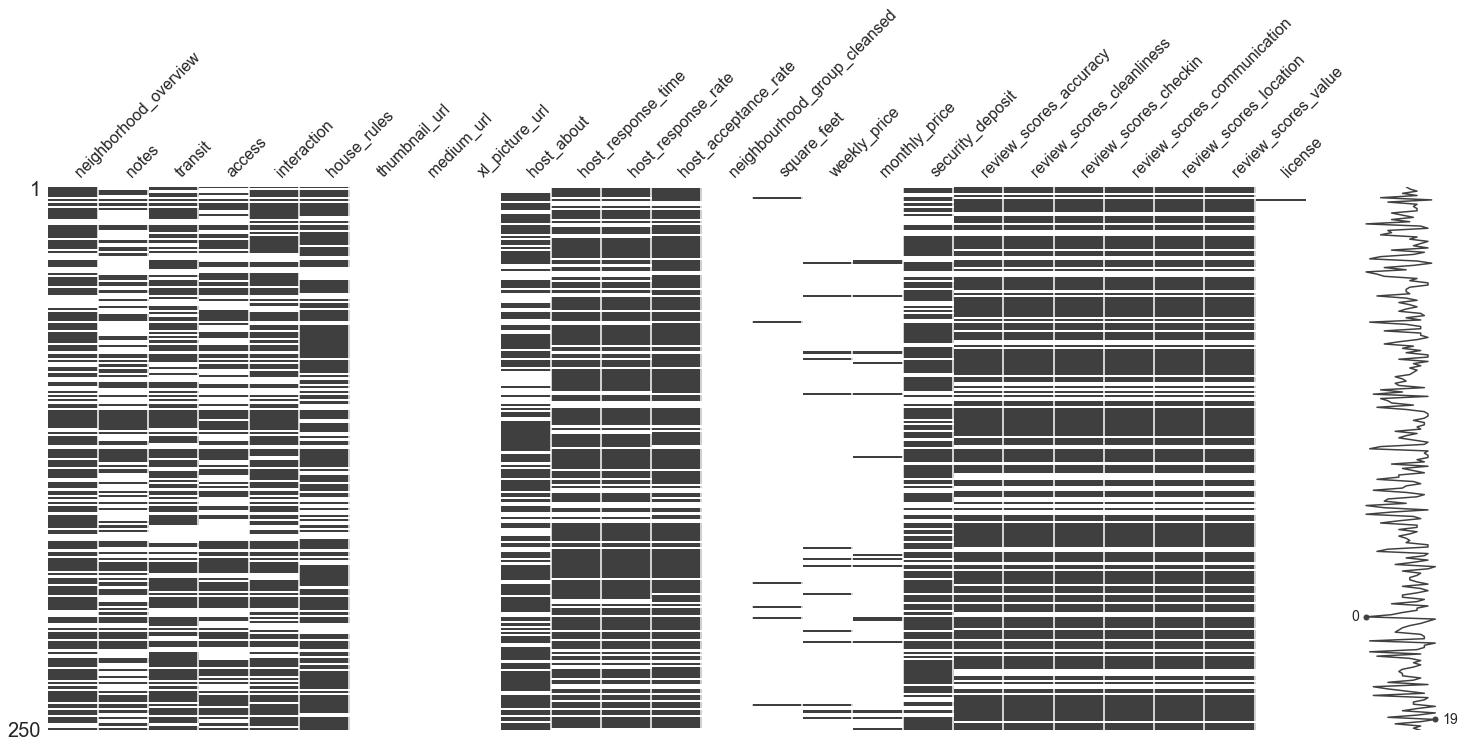

In [6]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=25, p=0.999) # or filter='top'
msno.matrix(filtered_data.sample(250))

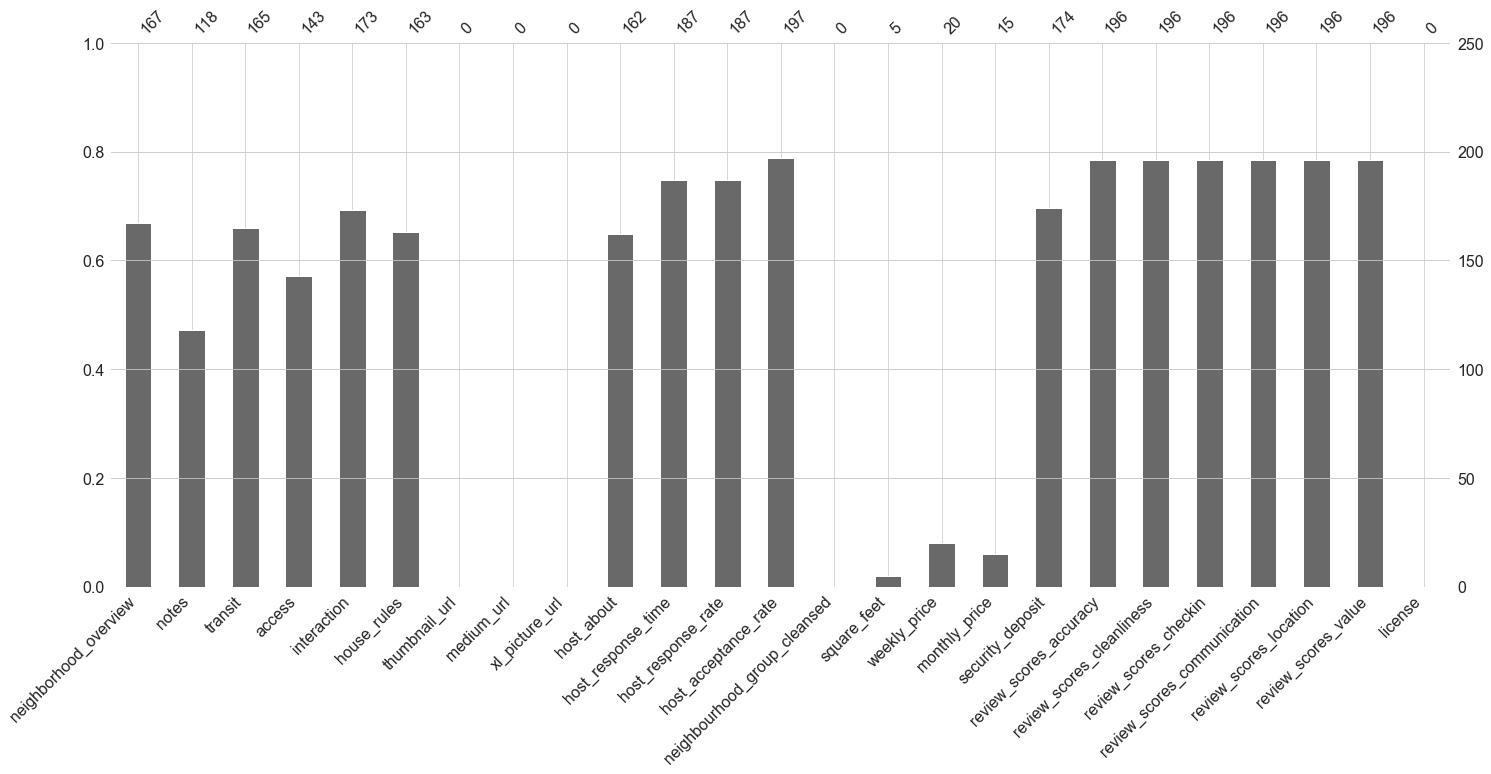

In [7]:
msno.bar(filtered_data.sample(250))

Features like 'square_feet', 'monthly_price' or 'weekly_price' have a lot of NULL values but we can use bedroom, bathroom, and accommodates data as a replacement for space size and also use 'price' for our prediction instead of 'monthly_price' or 'weekly_price'. 

#### Price (1):

In [8]:
df[['price','monthly_price', 'weekly_price']]

price monthly_price weekly_price
id                                          
2265      $225.00           NaN          NaN
5245      $100.00           NaN          NaN
5456       $95.00           NaN          NaN
5769       $40.00           NaN      $160.00
6413       $99.00     $1,900.00      $700.00
...           ...           ...          ...
42929742   $60.00           NaN          NaN
42930229   $40.00           NaN          NaN
42930678   $40.00           NaN          NaN
42930768   $45.00           NaN          NaN
42931550   $35.00           NaN          NaN

[11668 rows x 3 columns]

In [9]:
# Looking at describe() to get some insights on price and other numerical values
df.describe()

scrape_id  thumbnail_url  medium_url  xl_picture_url       host_id  \
count  1.166800e+04            0.0         0.0             0.0  1.166800e+04   
mean   2.020032e+13            NaN         NaN             NaN  7.673078e+07   
std    2.511826e+00            NaN         NaN             NaN  8.628560e+07   
min    2.020032e+13            NaN         NaN             NaN  2.300000e+01   
25%    2.020032e+13            NaN         NaN             NaN  8.761906e+06   
50%    2.020032e+13            NaN         NaN             NaN  3.939813e+07   
75%    2.020032e+13            NaN         NaN             NaN  1.185659e+08   
max    2.020032e+13            NaN         NaN             NaN  3.416244e+08   

       host_listings_count  host_total_listings_count  neighbourhood_cleansed  \
count         11666.000000               11666.000000            11668.000000   
mean             66.963398                  66.963398            78722.143469   
std             281.215856                 281.215856               20.689544   
min               0.000000                   0.000000            78701.000000   
25%               1.000000                   1.000000            78704.000000   
50%               1.000000                   1.000000            78717.000000   
75%               4.000000                   4.000000            78744.000000   
max            2016.000000                2016.000000            78759.000000   

       neighbourhood_group_cleansed       zipcode  ...  \
count                           0.0  11580.000000  ...   
mean                            NaN  78721.910535  ...   
std                             NaN     20.859859  ...   
min                             NaN  78617.000000  ...   
25%                             NaN  78703.000000  ...   
50%                             NaN  78705.000000  ...   
75%                             NaN  78744.000000  ...   
max                             NaN  78767.000000  ...   

       review_scores_cleanliness  review_scores_checkin  \
count                8999.000000            8998.000000   
mean                    9.607512               9.838964   
std                     0.838195               0.611808   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  8998.000000             8993.000000   
mean                      9.848188                9.779162   
std                       0.600158                0.615760   
min                       2.000000                2.000000   
25%                      10.000000               10.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  calculated_host_listings_count  \
count          8994.000000                    11668.000000   
mean              9.587725                       13.572506   
std               0.794404                       41.256138   
min               2.000000                        1.000000   
25%               9.000000                        1.000000   
50%              10.000000                        1.000000   
75%              10.000000                        4.000000   
max              10.000000                      248.000000   

       calculated_host_listings_count_entire_homes  \
count                                 11668.000000   
mean                                     12.477288   
std                                      41.041238   
min                                       0.000000   
25%                                       1.000000   
50%                                       1.000000   
75%     

Notice that 'price' is not included on the describe() above! Let's investigate why 'price' did not show up!

In [10]:
# describe for price
df['price'].head()

id
2265    $225.00
5245    $100.00
5456     $95.00
5769     $40.00
6413     $99.00
Name: price, dtype: object

'price' is type object and needs to be transformed to the correct data type.

In [11]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float, 2)

In [12]:
# Verify price type is float
df['price'].head()

id
2265    225.0
5245    100.0
5456     95.0
5769     40.0
6413     99.0
Name: price, dtype: float64

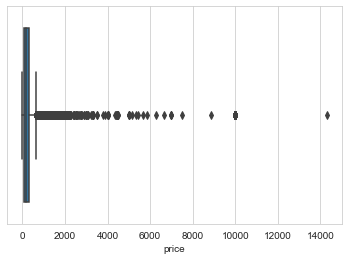

In [13]:
sns.boxplot(df['price'])

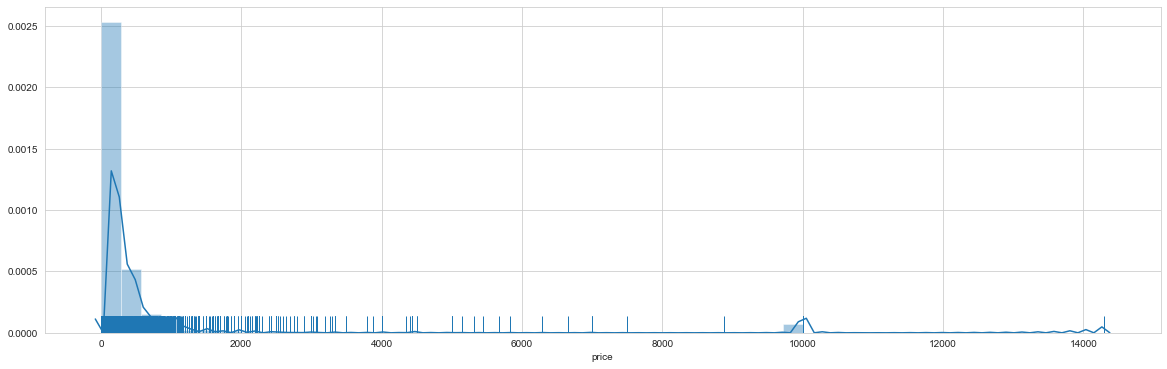

In [14]:
plt.figure(figsize=(20,6))
sns.distplot(df['price'], rug=True)

In [15]:
df['price'].isnull().sum()

0

In [16]:
df[df['price']==0][['bedrooms', 'bathrooms', 'price', 'accommodates', 'zipcode', 'listing_url']]

bedrooms  bathrooms  price  accommodates  zipcode  \
id                                                            
20269052       1.0        1.0    0.0             3  78701.0   
20541331       1.0        1.0    0.0             2  78704.0   
21378172       4.0        2.0    0.0            10  78704.0   

                                    listing_url  
id                                               
20269052  https://www.airbnb.com/rooms/20269052  
20541331  https://www.airbnb.com/rooms/20541331  
21378172  https://www.airbnb.com/rooms/21378172

In [17]:
df['price'].replace(0.0, np.nan, inplace=True)
df['price'].fillna(df.groupby(df['accommodates'])['price'].transform('median'), inplace=True)

In [18]:
print(df.loc[21378172]['price'])
print(df.loc[20541331]['price'])
print(df.loc[20269052]['price'])

450.0
80.0
100.0


In [19]:
'''df.at[21378172, 'price'] = 435
df.at[20541331, 'price'] = 130
df.at[20269052, 'price'] = 104'''

"df.at[21378172, 'price'] = 435\ndf.at[20541331, 'price'] = 130\ndf.at[20269052, 'price'] = 104"

In [20]:
# All these rentals for $1 /night are for Hurrican Harvey Refugees and haven't been updated since 2017 so we can drop them.
df[df['price']==1][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
20654658       0.0        0.0    1.0  https://www.airbnb.com/rooms/20654658
20674436       2.0        1.0    1.0  https://www.airbnb.com/rooms/20674436
20708014       1.0        1.5    1.0  https://www.airbnb.com/rooms/20708014
20780987       1.0        1.0    1.0  https://www.airbnb.com/rooms/20780987

In [21]:
df['price'].replace(1.0, np.nan, inplace=True)
#df.dropna(inplace=True) # Will drop NaN values at the end

In [22]:
df.loc[20654658]['price']

nan

In [23]:
df[df['price']==5][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
19840835       0.0        1.0    5.0  https://www.airbnb.com/rooms/19840835

In [24]:
df= df[df['price'] !=5.0]

In [25]:
df[df['price']==10][['bedrooms', 'bathrooms', 'price', 'listing_url']]

bedrooms  bathrooms  price                            listing_url
id                                                                         
10451030       1.0        1.0   10.0  https://www.airbnb.com/rooms/10451030
20647325       1.0        1.0   10.0  https://www.airbnb.com/rooms/20647325
20691399       1.0        1.0   10.0  https://www.airbnb.com/rooms/20691399
20713150       1.0        1.0   10.0  https://www.airbnb.com/rooms/20713150
21946737       1.0        1.0   10.0  https://www.airbnb.com/rooms/21946737
24208274       1.0        1.0   10.0  https://www.airbnb.com/rooms/24208274
32766208       5.0        5.5   10.0  https://www.airbnb.com/rooms/32766208
35315186       0.0        1.0   10.0  https://www.airbnb.com/rooms/35315186
36770125       0.0        1.0   10.0  https://www.airbnb.com/rooms/36770125

In [26]:
df= df[df['price'] !=10.0]

In [27]:
df[df['price']==14][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# All of these listings are for camp sites and can be marked as NaN and dropped later at the end

bedrooms  bathrooms  price                            listing_url
id                                                                         
372254         1.0        1.0   14.0    https://www.airbnb.com/rooms/372254
685447         1.0        1.0   14.0    https://www.airbnb.com/rooms/685447
685448         1.0        1.0   14.0    https://www.airbnb.com/rooms/685448
685451         0.0        1.0   14.0    https://www.airbnb.com/rooms/685451
936496         1.0        1.0   14.0    https://www.airbnb.com/rooms/936496
945803         0.0        1.0   14.0    https://www.airbnb.com/rooms/945803
968760        10.0        1.5   14.0    https://www.airbnb.com/rooms/968760
968817        10.0        1.0   14.0    https://www.airbnb.com/rooms/968817
12165731       1.0        1.0   14.0  https://www.airbnb.com/rooms/12165731
30123710       0.0        1.0   14.0  https://www.airbnb.com/rooms/30123710

In [28]:
df= df[df['price'] !=14.0]

In [29]:
df[df['price']==15][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# These are also camp sites listings and can be dropped

bedrooms  bathrooms  price                            listing_url
id                                                                         
15217595       0.0        0.0   15.0  https://www.airbnb.com/rooms/15217595
18849155       1.0        1.0   15.0  https://www.airbnb.com/rooms/18849155
39676879       0.0        1.0   15.0  https://www.airbnb.com/rooms/39676879

In [30]:
df= df[df['price'] !=15.0]

In [31]:
df[df['price']==16][['bedrooms', 'bathrooms', 'price', 'listing_url']]
# chekced url's randomly and these listings are reliable

bedrooms  bathrooms  price                            listing_url
id                                                                         
12336677       1.0        1.0   16.0  https://www.airbnb.com/rooms/12336677
14221592       1.0        2.0   16.0  https://www.airbnb.com/rooms/14221592
14463342       1.0        2.0   16.0  https://www.airbnb.com/rooms/14463342
14483719       1.0        2.0   16.0  https://www.airbnb.com/rooms/14483719
15034794       1.0        2.0   16.0  https://www.airbnb.com/rooms/15034794
16649075       1.0        1.0   16.0  https://www.airbnb.com/rooms/16649075
18787194       1.0        1.0   16.0  https://www.airbnb.com/rooms/18787194
18807173       1.0        1.0   16.0  https://www.airbnb.com/rooms/18807173
20439382       1.0        1.0   16.0  https://www.airbnb.com/rooms/20439382
20771704       1.0        1.0   16.0  https://www.airbnb.com/rooms/20771704
21307845       1.0        1.0   16.0  https://www.airbnb.com/rooms/21307845
21881708       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881708
21881807       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881807
21881859       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881859
21881893       1.0        1.0   16.0  https://www.airbnb.com/rooms/21881893
27021568       1.0        1.0   16.0  https://www.airbnb.com/rooms/27021568
27548039       1.0        3.0   16.0  https://www.airbnb.com/rooms/27548039
27579562       1.0        3.0   16.0  https://www.airbnb.com/rooms/27579562
27902782       1.0        1.0   16.0  https://www.airbnb.com/rooms/27902782
27903125       1.0        1.0   16.0  https://www.airbnb.com/rooms/27903125
33452080       1.0        1.0   16.0  https://www.airbnb.com/rooms/33452080
37291791       1.0        3.0   16.0  https://www.airbnb.com/rooms/37291791
37292336       1.0        3.0   16.0  https://www.airbnb.com/rooms/37292336
37449553       1.0        1.0   16.0  https://www.airbnb.com/rooms/37449553
37449692       1.0        1.0   16.0  https://www.airbnb.com/rooms/37449692

In [32]:
#df.loc[19840835]

In [33]:
#df.drop(df.index[[19840835, 10451030, 20647325, 20691399, 20713150, 21946737, 24208274, 32766208, 35315186, 36770125,
#                 372254, 685447, 685448, 685451, 936496, 945803, 968760, 968817, 12165731, 30123710,
#                 15217595, 18849155, 39676879]], axis=1, inplace=True)

In [34]:
df[df['price']<= 20]['property_type'].value_counts()

Apartment    37
House        10
Tipi          2
Bungalow      1
Townhouse     1
Cottage       1
Camper/RV     1
Other         1
Name: property_type, dtype: int64

In [35]:
df.price.describe()

count    11641.000000
mean       485.390688
std       1481.881108
min         16.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

Defined a mask for price based on below 25% quartile as 'low', below 50% as 'med' and the rest was set as 'high'

In [36]:
'''
price_bins=[]
for price in df.price:
    if price < 81:
        price_bins.append('low')
    if price < 150:
        price_bins.append('med')
    else:
        price_bins.append('high')
'''

"\nprice_bins=[]\nfor price in df.price:\n    if price < 81:\n        price_bins.append('low')\n    if price < 150:\n        price_bins.append('med')\n    else:\n        price_bins.append('high')\n"

In [37]:
#[[x,price_bins.count(x)] for x in set(price_bins)]

In [38]:
#df['price_bins'] = pd.Series(price_bins)

In [39]:
#df[['price', 'price_bins']]

In [40]:
#print(df['price_bins'].value_counts())
#df['price_bins'].value_counts().plot(kind='bar');

In [41]:
'''
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);
'''

"\nsns.set_style('ticks')\nfig, ax = plt.subplots()\nfig.set_size_inches(11, 8)\nsns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=ax);\n"

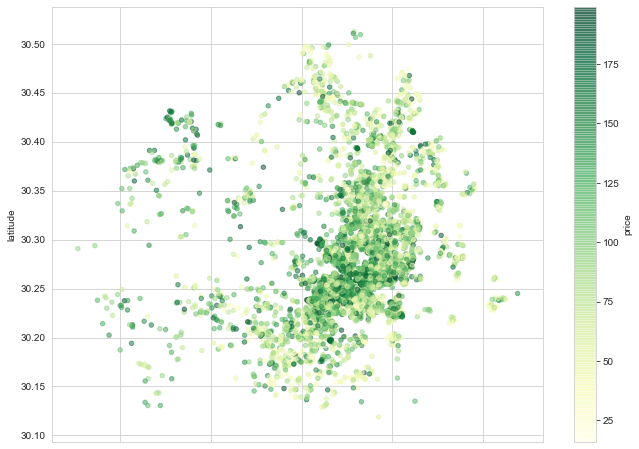

In [42]:
df[df['price']<200].plot.scatter(x='longitude', y='latitude', c='price', figsize=(11,8), cmap='YlGn', alpha=0.5);

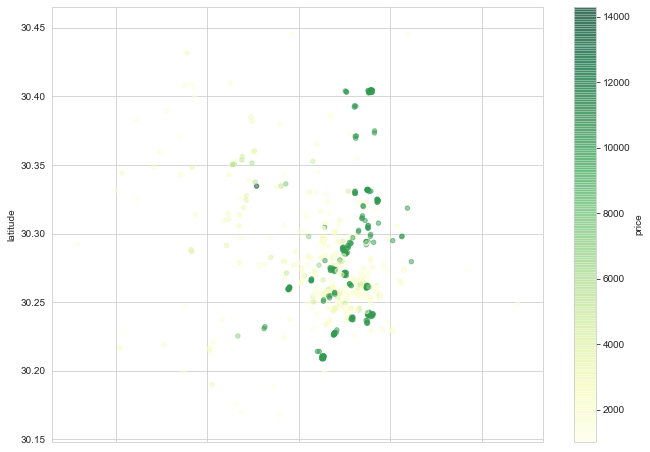

In [43]:
df[df['price']>1000].plot.scatter(x='longitude', y='latitude', c='price', figsize=(11,8), cmap='YlGn', alpha=0.5);

In [44]:
import plotly.express as px
fig = px.scatter(df, x="longitude", y="latitude", color='price', hover_data=['property_type'])
fig.show()

#### Property Type:

House                 5101
Apartment             3107
Condominium           1066
Guesthouse             538
Townhouse              416
Bungalow               298
Guest suite            270
Serviced apartment     166
Loft                   138
Camper/RV               90
Cottage                 68
Tiny house              64
Resort                  48
Villa                   44
Boutique hotel          39
Other                   39
Bed and breakfast       31
Hostel                  25
Aparthotel              24
Cabin                   17
Tent                     9
Farm stay                9
Boat                     6
Treehouse                5
Yurt                     4
Barn                     4
Hotel                    3
Tipi                     3
Houseboat                3
Dome house               3
Chalet                   2
Bus                      2
Earth house              1
Campsite                 1
Nature lodge             1
Name: property_type, dtype: int64


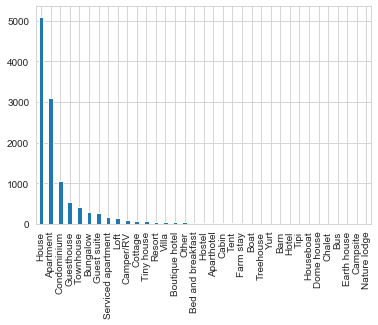

In [45]:
# Let's look at the property_type distribution
print(df['property_type'].value_counts())
df['property_type'].value_counts().plot(kind='bar');

In [46]:
df.groupby(df['property_type']== 'Apartment')['price'].median()

property_type
False    150.0
True     135.0
Name: price, dtype: float64

In [47]:
apartment = df[df['property_type']== 'Apartment'][['bedrooms', 'bathrooms', 'accommodates', 'price', 'listing_url']]
apartment[apartment['price'] >=10000].sort_values('accommodates', ascending=False)
# I checked some of these listings randomly and only 1 of them has the price of $10,000/night. I will replace the price
# with the median price associated to the accommodates rate

bedrooms  bathrooms  accommodates    price  \
id                                                     
37997840       4.0        2.0            10  10000.0   
37998870       4.0        2.0            10  10000.0   
41718441       4.0        2.0            10  10000.0   
39560085       2.0        1.0             6  10000.0   
39580699       2.0        2.0             6  10000.0   
...            ...        ...           ...      ...   
38214597       1.0        1.0             2  10000.0   
38212404       1.0        1.0             2  10000.0   
42455201       0.0        1.0             2  10000.0   
38209274       1.0        1.0             2  10000.0   
42454474       0.0        1.0             2  10000.0   

                                    listing_url  
id                                               
37997840  https://www.airbnb.com/rooms/37997840  
37998870  https://www.airbnb.com/rooms/37998870  
41718441  https://www.airbnb.com/rooms/41718441  
39560085  https://www.airbnb.com/rooms/39560085  
39580699  https://www.airbnb.com/rooms/39580699  
...                                         ...  
38214597  https://www.airbnb.com/rooms/38214597  
38212404  https://www.airbnb.com/rooms/38212404  
42455201  https://www.airbnb.com/rooms/42455201  
38209274  https://www.airbnb.com/rooms/38209274  
42454474  https://www.airbnb.com/rooms/42454474  

[241 rows x 5 columns]

In [48]:
df[df['property_type']== 'Apartment']['price'].median()

135.0

In [49]:
df[df['price'] >= 10000]['property_type'].unique()

array(['House', 'Apartment', 'Loft', 'Villa', 'Townhouse',
       'Boutique hotel'], dtype=object)

In [50]:
df[df['property_type'] == 'Villa']['price']

id
904354        650.0
1588655       975.0
1953384       219.0
7478179       600.0
9694801       975.0
11655929     1200.0
17316306      550.0
17576092     2500.0
18528005      375.0
19017960      489.0
20458467     1050.0
20760311      482.0
21162776      420.0
21164390      900.0
22408939     1300.0
23464327       30.0
26389105      350.0
27088626      400.0
30344991     1125.0
33374106     2699.0
35119272     1200.0
35119543     1699.0
35569192     4350.0
35839045     1000.0
35936760     1388.0
35936939     4000.0
36868035     3499.0
36868497     4999.0
36868599     3079.0
36868625    14298.0
36873295     2528.0
36874172     5832.0
36874378     3999.0
36874426     2749.0
36880518     6291.0
36903761     3266.0
36904204     1899.0
36909759     5669.0
36915288     5139.0
37078495     2639.0
39272801     5443.0
39272850     2528.0
41794019      666.0
42493257      290.0
Name: price, dtype: float64

In [51]:
df[df['property_type'] == 'Villa']['price'].median()

1344.0

In [52]:
df[df['property_type'] == 'House']['price']

id
2265        225.0
5245        100.0
5769         40.0
14913       300.0
21126       550.0
            ...  
42905997    308.0
42913208    300.0
42913493    300.0
42924521    100.0
42931550     35.0
Name: price, Length: 5101, dtype: float64

In [53]:
df[df['property_type'] == 'House']['price'].median()

174.0

In [54]:
#pd.options.display.max_rows = 60

In [55]:
df.groupby(['property_type', 'zipcode'])['price'].median()

property_type  zipcode
Aparthotel     78701.0     859.0
               78702.0    1075.0
Apartment      78653.0     140.0
               78660.0     110.0
               78701.0     227.0
                           ...  
Villa          78745.0     975.0
               78746.0    2724.0
               78759.0     290.0
Yurt           78742.0     100.0
               78751.0      89.5
Name: price, Length: 456, dtype: float64

In [56]:
df.zipcode.isnull().sum()

87

In [57]:
df.groupby(['property_type'])['price'].median()

property_type
Aparthotel             859.0
Apartment              135.0
Barn                   106.5
Bed and breakfast      137.0
Boat                   150.0
Boutique hotel         299.0
Bungalow               150.0
Bus                     69.0
Cabin                  142.5
Camper/RV               75.0
Campsite                40.0
Chalet                 389.5
Condominium            142.5
Cottage                130.0
Dome house             450.0
Earth house             95.0
Farm stay              130.0
Guest suite             89.0
Guesthouse             110.0
Hostel                  45.0
Hotel                  425.0
House                  174.0
Houseboat              250.0
Loft                   180.0
Nature lodge           180.0
Other                  100.0
Resort                 472.0
Serviced apartment     189.0
Tent                   100.0
Tiny house              85.0
Tipi                    19.0
Townhouse              134.0
Treehouse              111.0
Villa                 1344.0


In [58]:
df['price'].replace(10000.0, np.nan, inplace=True)
df['price'].fillna(df.groupby(['property_type'])['price'].transform('median'), inplace=True)

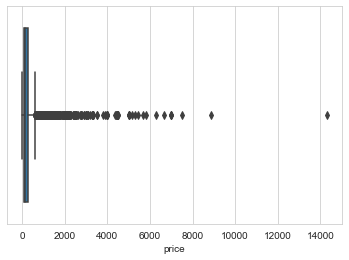

In [59]:
sns.boxplot(df['price'])

In [60]:
df['price'].replace(0.0, np.nan, inplace=True)
df['price'].fillna(df.groupby(df['accommodates'])['price'].transform('median'), inplace=True)

In [61]:
df[df['property_type'] == 'Villa'][['price', 'listing_url']].sort_values('price', ascending=False)

price                            listing_url
id                                                      
36868625  14298.0  https://www.airbnb.com/rooms/36868625
36880518   6291.0  https://www.airbnb.com/rooms/36880518
36874172   5832.0  https://www.airbnb.com/rooms/36874172
36909759   5669.0  https://www.airbnb.com/rooms/36909759
39272801   5443.0  https://www.airbnb.com/rooms/39272801
36915288   5139.0  https://www.airbnb.com/rooms/36915288
36868497   4999.0  https://www.airbnb.com/rooms/36868497
35569192   4350.0  https://www.airbnb.com/rooms/35569192
35936939   4000.0  https://www.airbnb.com/rooms/35936939
36874378   3999.0  https://www.airbnb.com/rooms/36874378
36868035   3499.0  https://www.airbnb.com/rooms/36868035
36903761   3266.0  https://www.airbnb.com/rooms/36903761
36868599   3079.0  https://www.airbnb.com/rooms/36868599
36874426   2749.0  https://www.airbnb.com/rooms/36874426
33374106   2699.0  https://www.airbnb.com/rooms/33374106
37078495   2639.0  https://www.airbnb.com/rooms/37078495
39272850   2528.0  https://www.airbnb.com/rooms/39272850
36873295   2528.0  https://www.airbnb.com/rooms/36873295
17576092   2500.0  https://www.airbnb.com/rooms/17576092
36904204   1899.0  https://www.airbnb.com/rooms/36904204
35119543   1699.0  https://www.airbnb.com/rooms/35119543
35936760   1388.0  https://www.airbnb.com/rooms/35936760
22408939   1300.0  https://www.airbnb.com/rooms/22408939
35119272   1200.0  https://www.airbnb.com/rooms/35119272
11655929   1200.0  https://www.airbnb.com/rooms/11655929
30344991   1125.0  https://www.airbnb.com/rooms/30344991
20458467   1050.0  https://www.airbnb.com/rooms/20458467
35839045   1000.0  https://www.airbnb.com/rooms/35839045
1588655     975.0   https://www.airbnb.com/rooms/1588655
9694801     975.0   https://www.airbnb.com/rooms/9694801
21164390    900.0  https://www.airbnb.com/rooms/21164390
41794019    666.0  https://www.airbnb.com/rooms/41794019
904354      650.0    https://www.airbnb.com/rooms/904354
7478179     600.0   https://www.airbnb.com/rooms/7478179
17316306    550.0  https://www.airbnb.com/rooms/17316306
19017960    489.0  https://www.airbnb.com/rooms/19017960
20760311    482.0  https://www.airbnb.com/rooms/20760311
21162776    420.0  https://www.airbnb.com/rooms/21162776
27088626    400.0  https://www.airbnb.com/rooms/27088626
18528005    375.0  https://www.airbnb.com/rooms/18528005
26389105    350.0  https://www.airbnb.com/rooms/26389105
42493257    290.0  https://www.airbnb.com/rooms/42493257
1953384     219.0   https://www.airbnb.com/rooms/1953384
23464327     30.0  https://www.airbnb.com/rooms/23464327

In [62]:
df.at[36868625, 'price'] = 9630

In [63]:
df[df['property_type'] == 'Villa'][['price', 'listing_url']].sort_values('price', ascending=False)

price                            listing_url
id                                                     
36868625  9630.0  https://www.airbnb.com/rooms/36868625
36880518  6291.0  https://www.airbnb.com/rooms/36880518
36874172  5832.0  https://www.airbnb.com/rooms/36874172
36909759  5669.0  https://www.airbnb.com/rooms/36909759
39272801  5443.0  https://www.airbnb.com/rooms/39272801
36915288  5139.0  https://www.airbnb.com/rooms/36915288
36868497  4999.0  https://www.airbnb.com/rooms/36868497
35569192  4350.0  https://www.airbnb.com/rooms/35569192
35936939  4000.0  https://www.airbnb.com/rooms/35936939
36874378  3999.0  https://www.airbnb.com/rooms/36874378
36868035  3499.0  https://www.airbnb.com/rooms/36868035
36903761  3266.0  https://www.airbnb.com/rooms/36903761
36868599  3079.0  https://www.airbnb.com/rooms/36868599
36874426  2749.0  https://www.airbnb.com/rooms/36874426
33374106  2699.0  https://www.airbnb.com/rooms/33374106
37078495  2639.0  https://www.airbnb.com/rooms/37078495
39272850  2528.0  https://www.airbnb.com/rooms/39272850
36873295  2528.0  https://www.airbnb.com/rooms/36873295
17576092  2500.0  https://www.airbnb.com/rooms/17576092
36904204  1899.0  https://www.airbnb.com/rooms/36904204
35119543  1699.0  https://www.airbnb.com/rooms/35119543
35936760  1388.0  https://www.airbnb.com/rooms/35936760
22408939  1300.0  https://www.airbnb.com/rooms/22408939
35119272  1200.0  https://www.airbnb.com/rooms/35119272
11655929  1200.0  https://www.airbnb.com/rooms/11655929
30344991  1125.0  https://www.airbnb.com/rooms/30344991
20458467  1050.0  https://www.airbnb.com/rooms/20458467
35839045  1000.0  https://www.airbnb.com/rooms/35839045
1588655    975.0   https://www.airbnb.com/rooms/1588655
9694801    975.0   https://www.airbnb.com/rooms/9694801
21164390   900.0  https://www.airbnb.com/rooms/21164390
41794019   666.0  https://www.airbnb.com/rooms/41794019
904354     650.0    https://www.airbnb.com/rooms/904354
7478179    600.0   https://www.airbnb.com/rooms/7478179
17316306   550.0  https://www.airbnb.com/rooms/17316306
19017960   489.0  https://www.airbnb.com/rooms/19017960
20760311   482.0  https://www.airbnb.com/rooms/20760311
21162776   420.0  https://www.airbnb.com/rooms/21162776
27088626   400.0  https://www.airbnb.com/rooms/27088626
18528005   375.0  https://www.airbnb.com/rooms/18528005
26389105   350.0  https://www.airbnb.com/rooms/26389105
42493257   290.0  https://www.airbnb.com/rooms/42493257
1953384    219.0   https://www.airbnb.com/rooms/1953384
23464327    30.0  https://www.airbnb.com/rooms/23464327

#### Room Type:

Entire home/apt    8833
Private room       2603
Shared room         158
Hotel room           51
Name: room_type, dtype: int64


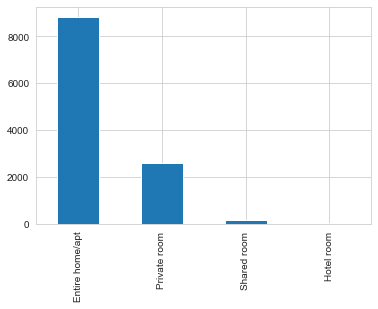

In [64]:
# Let's look at the room_type distribution
print(df['room_type'].value_counts())
df['room_type'].value_counts().plot(kind='bar');

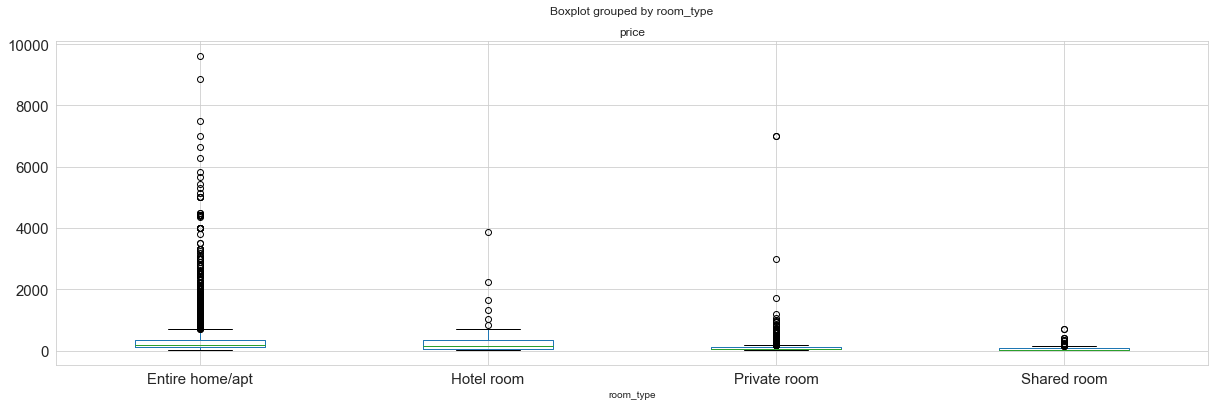

In [65]:
df.boxplot(column='price', by='room_type', figsize=(20,6), fontsize=15)

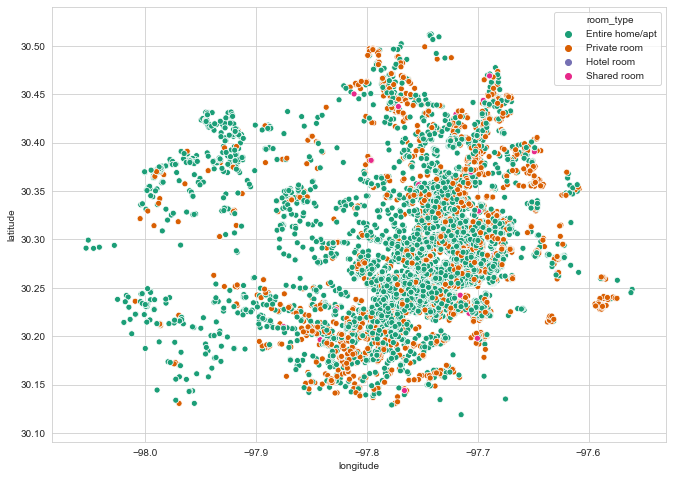

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='room_type', palette='Dark2', ax=ax);

In [67]:
#df['lat_long']= list(zip(df['latitude'], df['longitude']))

In [68]:
#df[['lat_long', 'latitude', 'longitude']]

#### Neighbourhood:

East Downtown          1086
Downtown                742
Travis Heights          462
University of Texas     434
East Riverside          374
                       ... 
Gateway                  22
Mesa Park                12
Cat Mountian             11
Walnut Creek              7
Canyon Mesa               6
Name: neighbourhood, Length: 78, dtype: int64


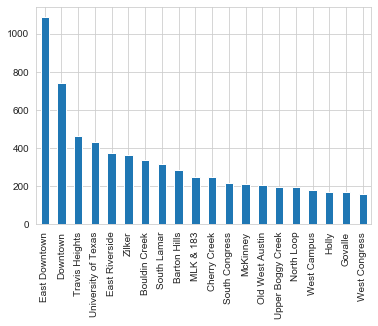

In [69]:
# Let's look at the neighbourhood distribution 
print(df['neighbourhood'].value_counts())
df['neighbourhood'].value_counts()[:20].plot(kind='bar');

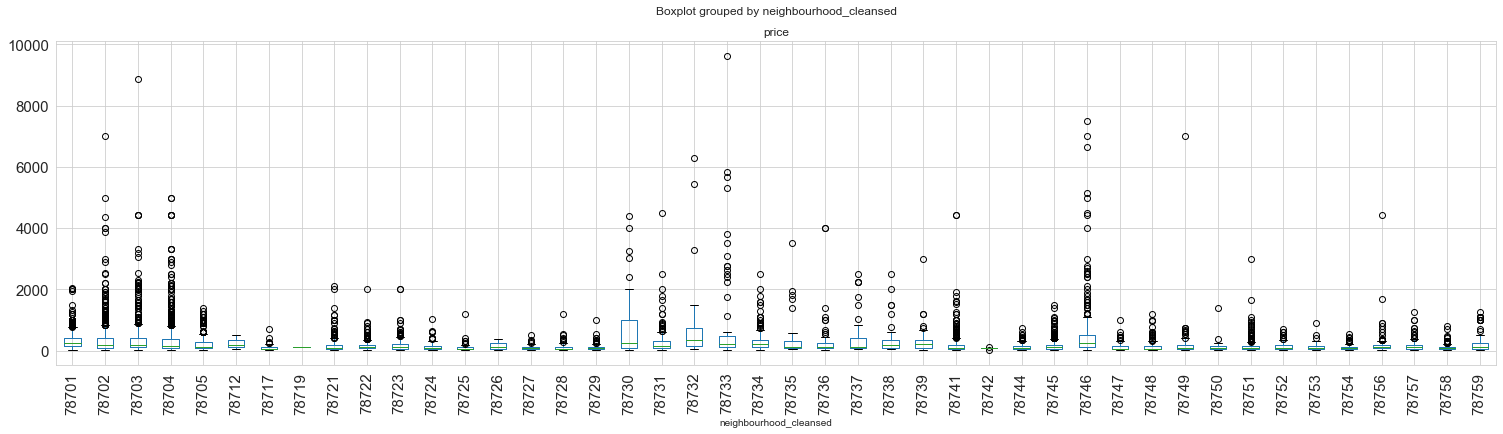

In [70]:
df.boxplot(column='price', by='neighbourhood_cleansed', figsize=(25,6), fontsize=15, rot=90)

In [71]:
df[['neighbourhood_cleansed', 'neighbourhood', 'neighbourhood_group_cleansed']]

neighbourhood_cleansed      neighbourhood  \
id                                                    
2265                       78702      East Downtown   
5245                       78702      East Downtown   
5456                       78702      East Downtown   
5769                       78729  SW Williamson Co.   
6413                       78704     Travis Heights   
...                          ...                ...   
42929742                   78704     South Congress   
42930229                   78741        Parker Lane   
42930678                   78741     East Riverside   
42930768                   78704     Travis Heights   
42931550                   78721           Downtown   

          neighbourhood_group_cleansed  
id                                      
2265                               NaN  
5245                               NaN  
5456                               NaN  
5769                               NaN  
6413                               NaN  
...                                ...  
42929742                           NaN  
42930229                           NaN  
42930678                           NaN  
42930768                           NaN  
42931550                           NaN  

[11645 rows x 3 columns]

In [72]:
df.last_review.isnull().sum()

2517

In [73]:
df['last_review'] = pd.to_datetime(df['last_review'])

In [74]:
(df.last_review.dt.year >= 2018).sum()

8172

In [75]:
columns_list = ['property_type', 'room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'longitude', 'latitude', 
                'number_of_reviews', 'availability_365', 'review_scores_rating', 
                'minimum_nights', 'listing_url']

df = df[columns_list]

In [76]:
df.head()

property_type        room_type  price  accommodates  bathrooms  bedrooms  \
id                                                                              
2265         House  Entire home/apt  225.0             4        2.0       2.0   
5245         House     Private room  100.0             2        1.0       1.0   
5456    Guesthouse  Entire home/apt   95.0             3        1.0       1.0   
5769         House     Private room   40.0             2        1.0       1.0   
6413    Guesthouse  Entire home/apt   99.0             2        1.0       0.0   

     host_is_superhost  neighbourhood_cleansed  longitude  latitude  \
id                                                                    
2265                 t                   78702  -97.71398  30.27750   
5245                 t                   78702  -97.71379  30.27577   
5456                 t                   78702  -97.73448  30.26112   
5769                 t                   78729  -97.78422  30.45697   
6413                 t                   78704  -97.73726  30.24829   

      number_of_reviews  availability_365  review_scores_rating  \
id                                                                
2265                 24                 0                  93.0   
5245                  9                 0                  91.0   
5456                529               334                  97.0   
5769                257                14                  98.0   
6413                112                 0                  99.0   

      minimum_nights                        listing_url  
id                                                       
2265              30  https://www.airbnb.com/rooms/2265  
5245              30  https://www.airbnb.com/rooms/5245  
5456               2  https://www.airbnb.com/rooms/5456  
5769               1  https://www.airbnb.com/rooms/5769  
6413               3  https://www.airbnb.com/rooms/6413

C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



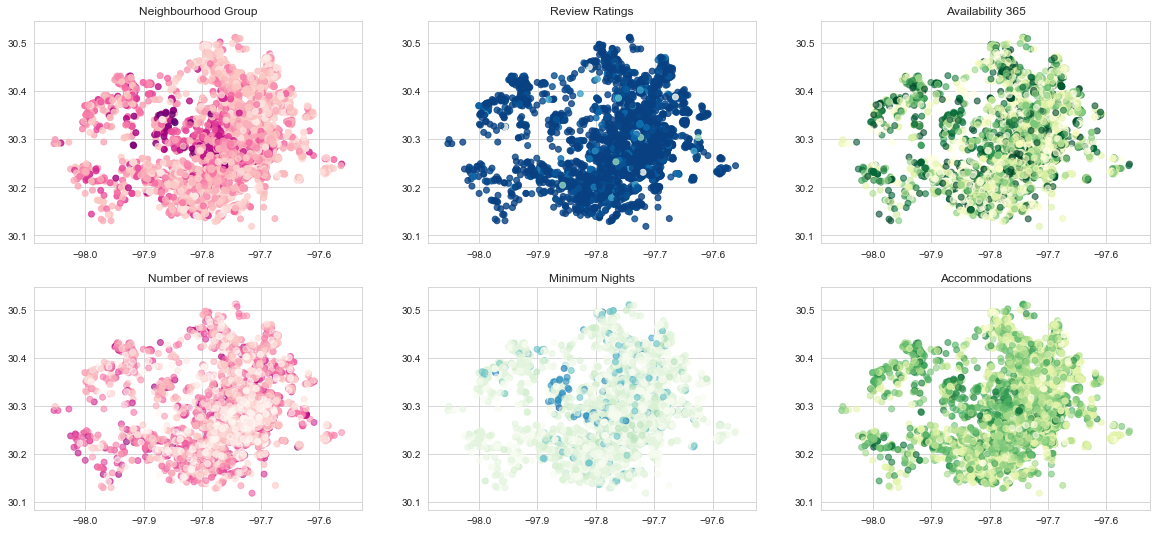

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Neighbourhood Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['review_scores_rating']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Review Ratings')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=df['availability_365'], cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['accommodates']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Accommodations')

plt.show()

Noting for cleanup:

* Price needs to be converted to float (This has been done already)
* Missing NaN values need data imputed or rows removed
* Categorical columns need to be converted to dummy variables (get_dummies)
* To continue the data exploration, I need to perform some cleanup procedures. I'll create a cleanup function to put these cleaning steps together.

In [78]:
print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11645 row entries.


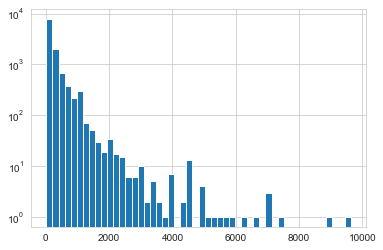

In [79]:
# Let's look at the rental price distribution
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

There are some oddly high prices (> $2000) that we need to examine to find out if the rental is a large proporty. We'll look at price per person (price / accommodates) to check for outliers.

In [80]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(15)

3500.000000    1
1750.000000    1
1500.000000    1
1200.000000    1
1081.000000    1
980.000000     1
937.500000     1
875.000000     1
833.333333     1
815.000000     1
802.500000     1
800.000000     1
750.000000     3
740.000000     1
717.000000     1
Name: price_per_person, dtype: int64

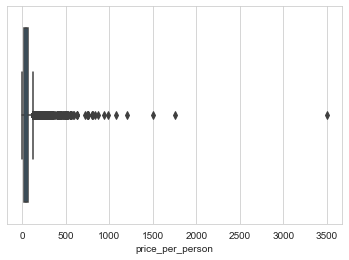

In [81]:
sns.boxplot(df['price_per_person'])

In [82]:
df[df['price_per_person'] > 1500.00][['price', 'number_of_reviews', 'accommodates']].sort_values('price', ascending=False)

price  number_of_reviews  accommodates
id                                               
925980    7000.0                  2             4
42091432  7000.0                  0             2

In [83]:
df[df['price_per_person'] <= 1500].price.value_counts().sort_index()

16.0      25
18.0       4
19.0       6
20.0      19
21.0       4
          ..
6660.0     1
7000.0     1
7500.0     1
8880.0     1
9630.0     1
Name: price, Length: 700, dtype: int64

In [84]:
df.loc[df['price'] == 10000.0]

Empty DataFrame
Columns: [property_type, room_type, price, accommodates, bathrooms, bedrooms, host_is_superhost, neighbourhood_cleansed, longitude, latitude, number_of_reviews, availability_365, review_scores_rating, minimum_nights, listing_url, price_per_person]
Index: []

Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers.

In [85]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1500.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1500.0    1
1200.0    1
1081.0    1
980.0     1
937.5     1
Name: price_per_person, dtype: int64

In [86]:
df.describe()

price  accommodates     bathrooms      bedrooms  \
count  11643.000000  11643.000000  11630.000000  11628.000000   
mean     271.797604      4.701366      1.544755      1.786980   
std      438.477156      3.237157      0.873648      1.268582   
min       16.000000      1.000000      0.000000      0.000000   
25%       80.000000      2.000000      1.000000      1.000000   
50%      139.000000      4.000000      1.000000      1.000000   
75%      295.500000      6.000000      2.000000      2.000000   
max     9630.000000     33.000000     17.000000     23.000000   

       neighbourhood_cleansed     longitude      latitude  number_of_reviews  \
count            11643.000000  11643.000000  11643.000000       11643.000000   
mean             78722.124710    -97.751153     30.278140          31.753758   
std                 20.690699      0.056397      0.057414          63.635921   
min              78701.000000    -98.053550     30.118850           0.000000   
25%              78704.000000    -97.767205     30.244355           1.000000   
50%              78717.000000    -97.744800     30.266860           7.000000   
75%              78744.000000    -97.721365     30.298535          32.000000   
max              78759.000000    -97.560620     30.512280         947.000000   

       availability_365  review_scores_rating  minimum_nights  \
count      11643.000000           8998.000000    11643.000000   
mean         134.198574             95.973772        5.289101   
std          134.516810              7.205581       16.639510   
min            0.000000             20.000000        1.000000   
25%            0.000000             95.000000        1.000000   
50%           87.000000             98.000000        2.000000   
75%          268.000000            100.000000        2.000000   
max          365.000000            100.000000      500.000000   

       price_per_person  
count      11643.000000  
mean          57.431703  
std           68.603594  
min            1.727273  
25%           25.000000  
50%           37.500000  
75%           62.500000  
max         1500.000000

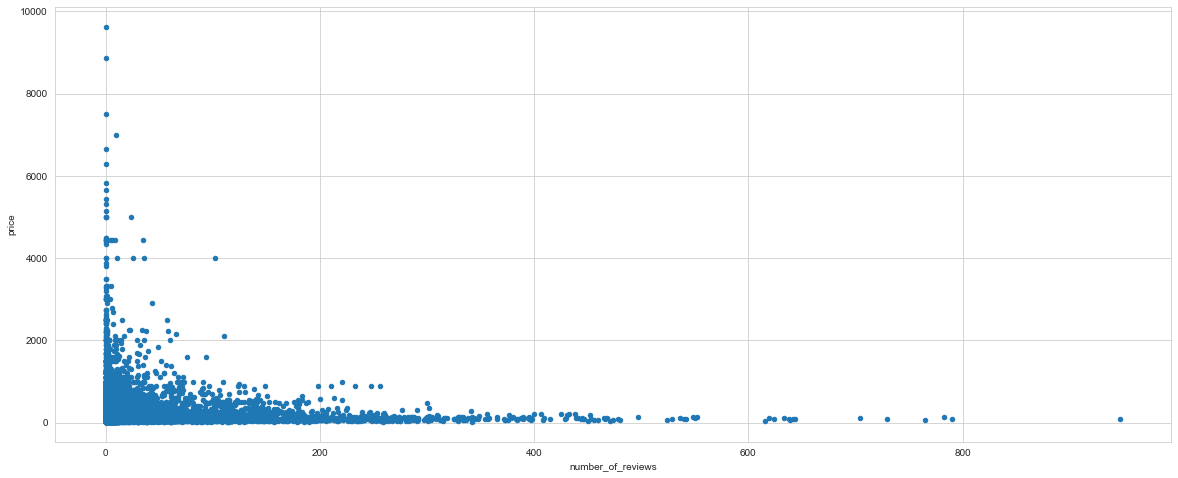

In [87]:
df.plot.scatter(x='number_of_reviews', y='price', figsize=(20,8))

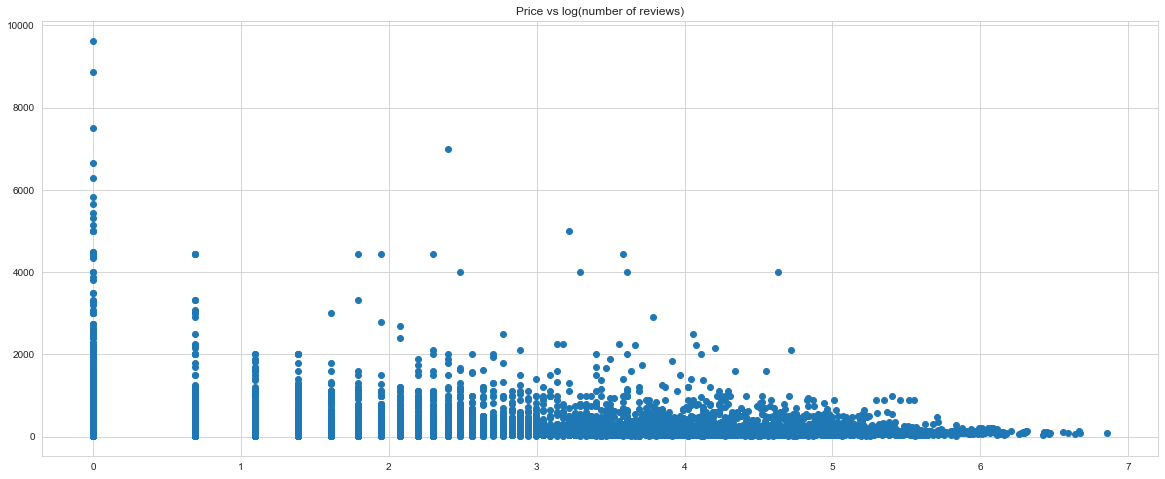

In [88]:
plt.figure(figsize=(20,8))
plt.scatter(np.log(1+df['number_of_reviews']), df['price'])
plt.title('Price vs log(number of reviews)');

The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [89]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling NaN 'review_scores_rating' with 95.974.


The bathrooms feature is missing some data. I'll update the NaNs based on the standard ratio of the number of bathrooms needed in a home which is two for every three rooms. I'll assign a bathroom for every 2 people.

#### Bathrooms:

In [90]:
df['bathrooms'].isnull().sum()

13

In [91]:
df.groupby(df['bathrooms']== 0).size()

bathrooms
False    11609
True        34
dtype: int64

In [92]:
df['bedrooms'].isnull().sum()

15

In [93]:
df.groupby(df['bedrooms']== 0).size()

bedrooms
False    10936
True       707
dtype: int64

In [94]:
# Replacing all 0 values in bathrooms with 'NaN'
df['bathrooms'].replace(0, np.nan, inplace=True)
df['bathrooms'].fillna(df.groupby(df['accommodates'])['bathrooms'].transform('median'), inplace=True)

In [95]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
#df['bathrooms'].fillna((df['accommodates']//2), inplace=True)

In [96]:
# Check to make sure bathrooms NaN values have been filled correctly. 
df.loc[[314152]]

property_type        room_type  price  accommodates  bathrooms  \
id                                                                      
314152     Apartment  Entire home/apt  350.0             4        1.0   

        bedrooms host_is_superhost  neighbourhood_cleansed  longitude  \
id                                                                      
314152       2.0                 f                   78730  -97.79621   

        latitude  number_of_reviews  availability_365  review_scores_rating  \
id                                                                            
314152  30.35672                  0                 0             95.973772   

        minimum_nights                          listing_url  price_per_person  
id                                                                             
314152               4  https://www.airbnb.com/rooms/314152              87.5

In [97]:
df[df['accommodates'] == 4]['bathrooms'].mean()

1.2534642032332564

In [98]:
df[df['bedrooms'] == 4]['bathrooms'].mean()

2.816473988439306

In [99]:
df[df['accommodates']== 4]['bedrooms'].median()

1.0

In [100]:
df[df['accommodates'] == 3]['bathrooms'].mean()

1.0703043022035676

In [101]:
df['accommodates'].isnull().sum()

0

In [102]:
df.groupby(df['accommodates']== 0).size()

accommodates
False    11643
dtype: int64

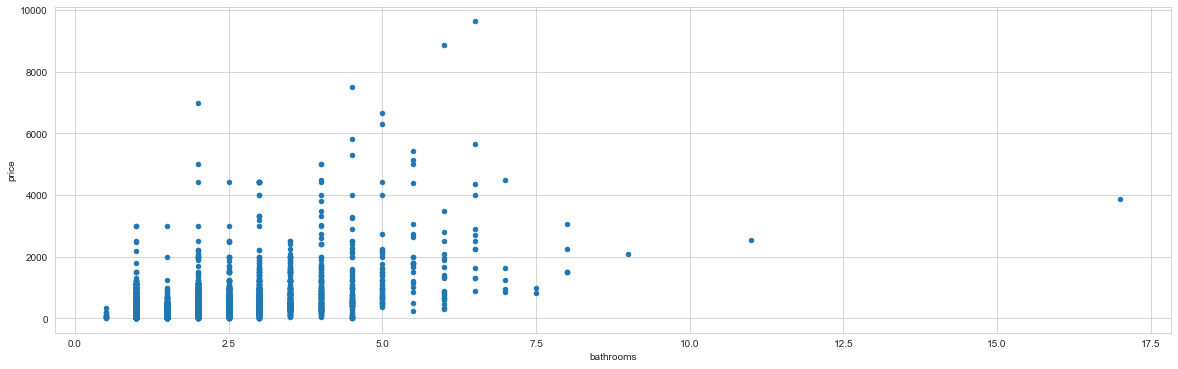

In [103]:
df.plot.scatter(x='bathrooms', y='price', figsize=(20,6))

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11643 entries, 2265 to 42931550
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           11643 non-null  object 
 1   room_type               11643 non-null  object 
 2   price                   11643 non-null  float64
 3   accommodates            11643 non-null  int64  
 4   bathrooms               11643 non-null  float64
 5   bedrooms                11628 non-null  float64
 6   host_is_superhost       11641 non-null  object 
 7   neighbourhood_cleansed  11643 non-null  int64  
 8   longitude               11643 non-null  float64
 9   latitude                11643 non-null  float64
 10  number_of_reviews       11643 non-null  int64  
 11  availability_365        11643 non-null  int64  
 12  review_scores_rating    11643 non-null  float64
 13  minimum_nights          11643 non-null  int64  
 14  listing_url             11643 no

In [105]:
df.isnull().sum()

property_type              0
room_type                  0
price                      0
accommodates               0
bathrooms                  0
bedrooms                  15
host_is_superhost          2
neighbourhood_cleansed     0
longitude                  0
latitude                   0
number_of_reviews          0
availability_365           0
review_scores_rating       0
minimum_nights             0
listing_url                0
price_per_person           0
dtype: int64

#### Bedrooms:

In [106]:
df[df['bedrooms'].isnull()].head()

property_type        room_type  price  accommodates  bathrooms  \
id                                                                        
38819415     Camper/RV  Entire home/apt  100.0             2        1.0   
38955548     Apartment  Entire home/apt  100.0             2        1.0   
40171545     Apartment  Entire home/apt   80.0             4        1.0   
42145069     Apartment  Entire home/apt   80.0             2        1.0   
42485149    Guesthouse  Entire home/apt   85.0             2        1.0   

          bedrooms host_is_superhost  neighbourhood_cleansed  longitude  \
id                                                                        
38819415       NaN                 f                   78701  -97.73815   
38955548       NaN                 t                   78704  -97.76369   
40171545       NaN                 f                   78722  -97.70992   
42145069       NaN                 t                   78758  -97.72143   
42485149       NaN                 f                   78723  -97.67123   

          latitude  number_of_reviews  availability_365  review_scores_rating  \
id                                                                              
38819415  30.27715                  0               177             95.973772   
38955548  30.25503                 28                31             99.000000   
40171545  30.28476                  4                88            100.000000   
42145069  30.39580                  5               344            100.000000   
42485149  30.31082                  0               259             95.973772   

          minimum_nights                            listing_url  \
id                                                                
38819415               5  https://www.airbnb.com/rooms/38819415   
38955548               2  https://www.airbnb.com/rooms/38955548   
40171545               1  https://www.airbnb.com/rooms/40171545   
42145069               1  https://www.airbnb.com/rooms/42145069   
42485149               1  https://www.airbnb.com/rooms/42485149   

          price_per_person  
id                          
38819415              50.0  
38955548              50.0  
40171545              20.0  
42145069              40.0  
42485149              42.5

In [107]:
(df['bathrooms'] == 0).sum()

0

In [108]:
df[df['bedrooms'] == 0]

property_type        room_type  price  accommodates  bathrooms  \
id                                                                        
6413        Guesthouse  Entire home/apt   99.0             2        1.0   
56690        Apartment  Entire home/apt  150.0             2        1.0   
141550      Guesthouse  Entire home/apt  111.0             3        1.0   
219168       Apartment  Entire home/apt  250.0             2        1.0   
224603      Guesthouse  Entire home/apt  105.0             2        1.0   
...                ...              ...    ...           ...        ...   
42852666   Condominium  Entire home/apt  220.0             4        1.0   
42866299    Tiny house  Entire home/apt  150.0             4        1.0   
42883474     Apartment  Entire home/apt  300.0             4        1.0   
42911518     Apartment  Entire home/apt   58.0             3        1.0   
42924521         House     Private room  100.0             2        1.0   

          bedrooms host_is_superhost  neighbourhood_cleansed  longitude  \
id                                                                        
6413           0.0                 t                   78704  -97.73726   
56690          0.0                 t                   78704  -97.75121   
141550         0.0                 t                   78702  -97.72709   
219168         0.0                 f                   78704  -97.74531   
224603         0.0                 f                   78751  -97.72679   
...            ...               ...                     ...        ...   
42852666       0.0                 f                   78701  -97.74723   
42866299       0.0                 f                   78702  -97.71823   
42883474       0.0                 f                   78701  -97.74853   
42911518       0.0                 f                   78704  -97.78339   
42924521       0.0                 f                   78754  -97.64904   

          latitude  number_of_reviews  availability_365  review_scores_rating  \
id                                                                              
6413      30.24829                112                 0             99.000000   
56690     30.24440                169                77             99.000000   
141550    30.25582                439               163             97.000000   
219168    30.24503                180                 0            100.000000   
224603    30.30788                104               102             99.000000   
...            ...                ...               ...                   ...   
42852666  30.27088                  0               273             95.973772   
42866299  30.26515                  2               178            100.000000   
42883474  30.27276                  0                 5             95.973772   
42911518  30.23763                  0                34             95.973772   
42924521  30.36566                  0                83             95.973772   

          minimum_nights                            listing_url  \
id                                                                
6413                   3      https://www.airbnb.com/rooms/6413   
56690                  2     https://www.airbnb.com/rooms/56690   
141550                 1    https://www.airbnb.com/rooms/141550   
219168                 2    https://www.airbnb.com/rooms/219168   
224603                30    https://www.airbnb.com/rooms/224603   
...                  ...                                    ...   
42852666               3  https://www.airbnb.com/rooms/42852666   
42866299               2  https://www.airbnb.com/rooms/42866299   
42883474               3  https://www.airbnb.com/rooms/42883474   
42911518               1  https://www.airbnb.com/rooms/42911518   
42924521               1  https://www.airbnb.com/rooms/42924521   

          price_per_person  
id                          
6413             49.500000  
56690            75.000000  
141550         

In [109]:
df[df['bedrooms'] == 0].room_type.value_counts()

Entire home/apt    663
Private room        44
Name: room_type, dtype: int64

In [110]:
df[df['bedrooms'] == 0].accommodates.value_counts()

2     367
4     173
3     124
1      14
5      12
6       8
8       3
11      2
10      2
12      1
7       1
Name: accommodates, dtype: int64

In [111]:
# Replacing all 0 values in bedrooms with 'NaN'
df['bedrooms'].replace(0, np.nan, inplace=True)

In [112]:
df['bedrooms'].fillna(df.groupby(df['accommodates'])['bedrooms'].transform('median'), inplace=True)

In [113]:
df.loc[42852666]

property_type                                       Condominium
room_type                                       Entire home/apt
price                                                       220
accommodates                                                  4
bathrooms                                                     1
bedrooms                                                      1
host_is_superhost                                             f
neighbourhood_cleansed                                    78701
longitude                                              -97.7472
latitude                                                30.2709
number_of_reviews                                             0
availability_365                                            273
review_scores_rating                                    95.9738
minimum_nights                                                3
listing_url               https://www.airbnb.com/rooms/42852666
price_per_person                        

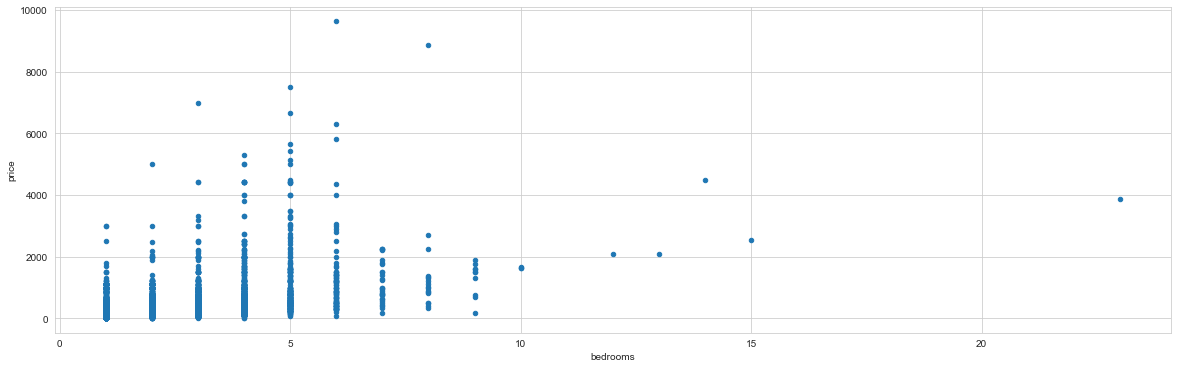

In [114]:
df.plot.scatter(x='bedrooms', y='price', figsize=(20,6))

In [115]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US.

In [116]:
df['bathrooms'].value_counts().sort_index(ascending=False)

17.0       1
11.0       1
9.0        1
8.0        5
7.5        2
7.0        5
6.5       13
6.0       21
5.5       21
5.0       47
4.5       79
4.0      141
3.5      186
3.0      418
2.5      775
2.0     2270
1.5      762
1.0     6879
0.5       14
Name: bathrooms, dtype: int64

In [117]:
df.groupby('bathrooms').price.median()

bathrooms
0.5       70.5
1.0      102.0
1.5      100.0
2.0      242.0
2.5      300.0
3.0      495.0
3.5      600.0
4.0      733.0
4.5      700.0
5.0     1100.0
5.5     1800.0
6.0     1300.0
6.5     2500.0
7.0     1250.0
7.5      920.0
8.0     1500.0
9.0     2100.0
11.0    2550.0
17.0    3875.0
Name: price, dtype: float64

In [118]:
df['accommodates'].value_counts().sort_index(ascending=False)

33       1
32       2
30       1
28       2
25       1
24       4
21       3
20       2
19       2
18       4
17       1
16     245
15      27
14      79
13      30
12     178
11      41
10     425
9      103
8      681
7      250
6     1674
5      637
4     2598
3      953
2     3241
1      456
Name: accommodates, dtype: int64

In [119]:
df.groupby('accommodates').price.mean()

accommodates
1       78.879386
2      116.376736
3      138.338405
4      233.340262
5      236.199372
6      315.376344
7      347.716000
8      529.753304
9      505.844660
10     691.345882
11     729.975610
12     760.876404
13     629.366667
14     918.518987
15     985.740741
16     860.481633
17    1170.000000
18    3776.750000
19    1740.000000
20    2387.500000
21    1722.000000
24    1404.250000
25     633.000000
28    1370.000000
30    2749.000000
32    1882.500000
33    1780.000000
Name: price, dtype: float64

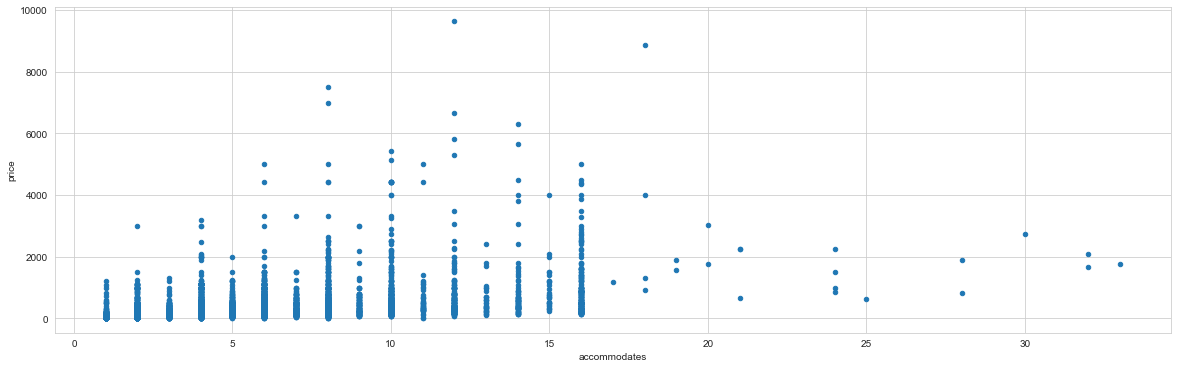

In [120]:
df.plot.scatter(x='accommodates', y='price', figsize=(20,6));

In [121]:
print(df[df['bathrooms'] <= 8])
print(df[df['accommodates'] <= 16])
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

         property_type        room_type  price  accommodates  bathrooms  \
id                                                                        
2265             House  Entire home/apt  225.0             4        2.0   
5245             House     Private room  100.0             2        1.0   
5456        Guesthouse  Entire home/apt   95.0             3        1.0   
5769             House     Private room   40.0             2        1.0   
6413        Guesthouse  Entire home/apt   99.0             2        1.0   
...                ...              ...    ...           ...        ...   
42929742     Apartment  Entire home/apt   60.0             1        1.0   
42930229     Apartment  Entire home/apt   40.0             3        1.0   
42930678     Apartment  Entire home/apt   40.0             3        1.0   
42930768     Apartment  Entire home/apt   45.0             3        1.0   
42931550         House     Private room   35.0             6        1.0   

          bedrooms host_

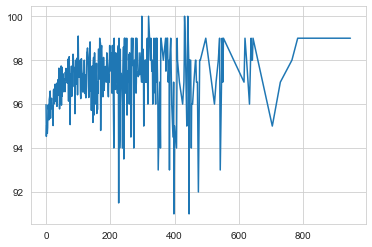

In [122]:
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality
Need to verify that price is a float, review_scores_rating are not missing any values.

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11615 entries, 2265 to 42931550
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           11615 non-null  object 
 1   room_type               11615 non-null  object 
 2   price                   11615 non-null  float64
 3   accommodates            11615 non-null  int64  
 4   bathrooms               11615 non-null  float64
 5   bedrooms                11615 non-null  float64
 6   host_is_superhost       11615 non-null  object 
 7   neighbourhood_cleansed  11615 non-null  int64  
 8   longitude               11615 non-null  float64
 9   latitude                11615 non-null  float64
 10  number_of_reviews       11615 non-null  int64  
 11  availability_365        11615 non-null  int64  
 12  review_scores_rating    11615 non-null  float64
 13  minimum_nights          11615 non-null  int64  
 14  listing_url             11615 no

### Data Preparation 
The data preparation process in the CRISP-DM cycle consists of:

* Select your data
* Clean your data
* Construct required data
* Integrate data (not required for this project)

#### Select your data
* This is the stage of the project where you decide on the data that you're going to use for analysis. [source](https://www.sv-europe.com/crisp-dm-methodology/). To answer the business questions posed at the beginning, I'm choosing to keep the following features:

* 'price' - target feature for the business questions
* 'room_type' - property type: house, private room, shared room
* 'accommodates' - property size metric
* 'bathrooms' - property size metric
* 'bedrooms' - property size metric
* 'host_is_superhost' - Airbnb host status
* 'neighbourhood_cleansed' - Location, ZIP code
* 'number_of_reviews' - Review metric
* 'review_scores_rating' - Review metric
* 'minimum_nights' - length of stay metric

#### Clean your data
This task involves raise the data quality to the level required by the analysis techniques that you've selected [source](https://www.sv-europe.com/crisp-dm-methodology/). I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook.

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11615 entries, 2265 to 42931550
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           11615 non-null  object 
 1   room_type               11615 non-null  object 
 2   price                   11615 non-null  float64
 3   accommodates            11615 non-null  int64  
 4   bathrooms               11615 non-null  float64
 5   bedrooms                11615 non-null  float64
 6   host_is_superhost       11615 non-null  object 
 7   neighbourhood_cleansed  11615 non-null  int64  
 8   longitude               11615 non-null  float64
 9   latitude                11615 non-null  float64
 10  number_of_reviews       11615 non-null  int64  
 11  availability_365        11615 non-null  int64  
 12  review_scores_rating    11615 non-null  float64
 13  minimum_nights          11615 non-null  int64  
 14  listing_url             11615 no

In [125]:
#df_no_impute.count()

In [126]:
#df_zeros_impute.count()

### Construct required data
This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. source

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes.

Additionally, I need to create dummy variables and scale the features for the regression models.

In [127]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [128]:
df.head()

property_type        room_type  price  accommodates  bathrooms  bedrooms  \
id                                                                              
2265         House  Entire home/apt  225.0             4        2.0       2.0   
5245         House     Private room  100.0             2        1.0       1.0   
5456    Guesthouse  Entire home/apt   95.0             3        1.0       1.0   
5769         House     Private room   40.0             2        1.0       1.0   
6413    Guesthouse  Entire home/apt   99.0             2        1.0       1.0   

     host_is_superhost  longitude  latitude  number_of_reviews  \
id                                                               
2265                 t  -97.71398  30.27750                 24   
5245                 t  -97.71379  30.27577                  9   
5456                 t  -97.73448  30.26112                529   
5769                 t  -97.78422  30.45697                257   
6413                 t  -97.73726  30.24829                112   

      availability_365  review_scores_rating  minimum_nights  \
id                                                             
2265                 0                  93.0              30   
5245                 0                  91.0              30   
5456               334                  97.0               2   
5769                14                  98.0               1   
6413                 0                  99.0               3   

                            listing_url  price_per_person   region  
id                                                                  
2265  https://www.airbnb.com/rooms/2265         56.250000  Central  
5245  https://www.airbnb.com/rooms/5245         50.000000  Central  
5456  https://www.airbnb.com/rooms/5456         31.666667  Central  
5769  https://www.airbnb.com/rooms/5769         20.000000    North  
6413  https://www.airbnb.com/rooms/6413         49.500000  Central

In [129]:
print (np.corrcoef(df['bedrooms'], df['accommodates']))

[[1.         0.82600772]
 [0.82600772 1.        ]]


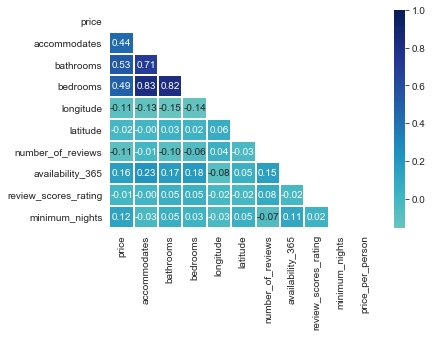

In [130]:
#Create the correlation matrix
corr= df.corr()[:10]
# Draw the heatmap

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap="YlGnBu", center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()


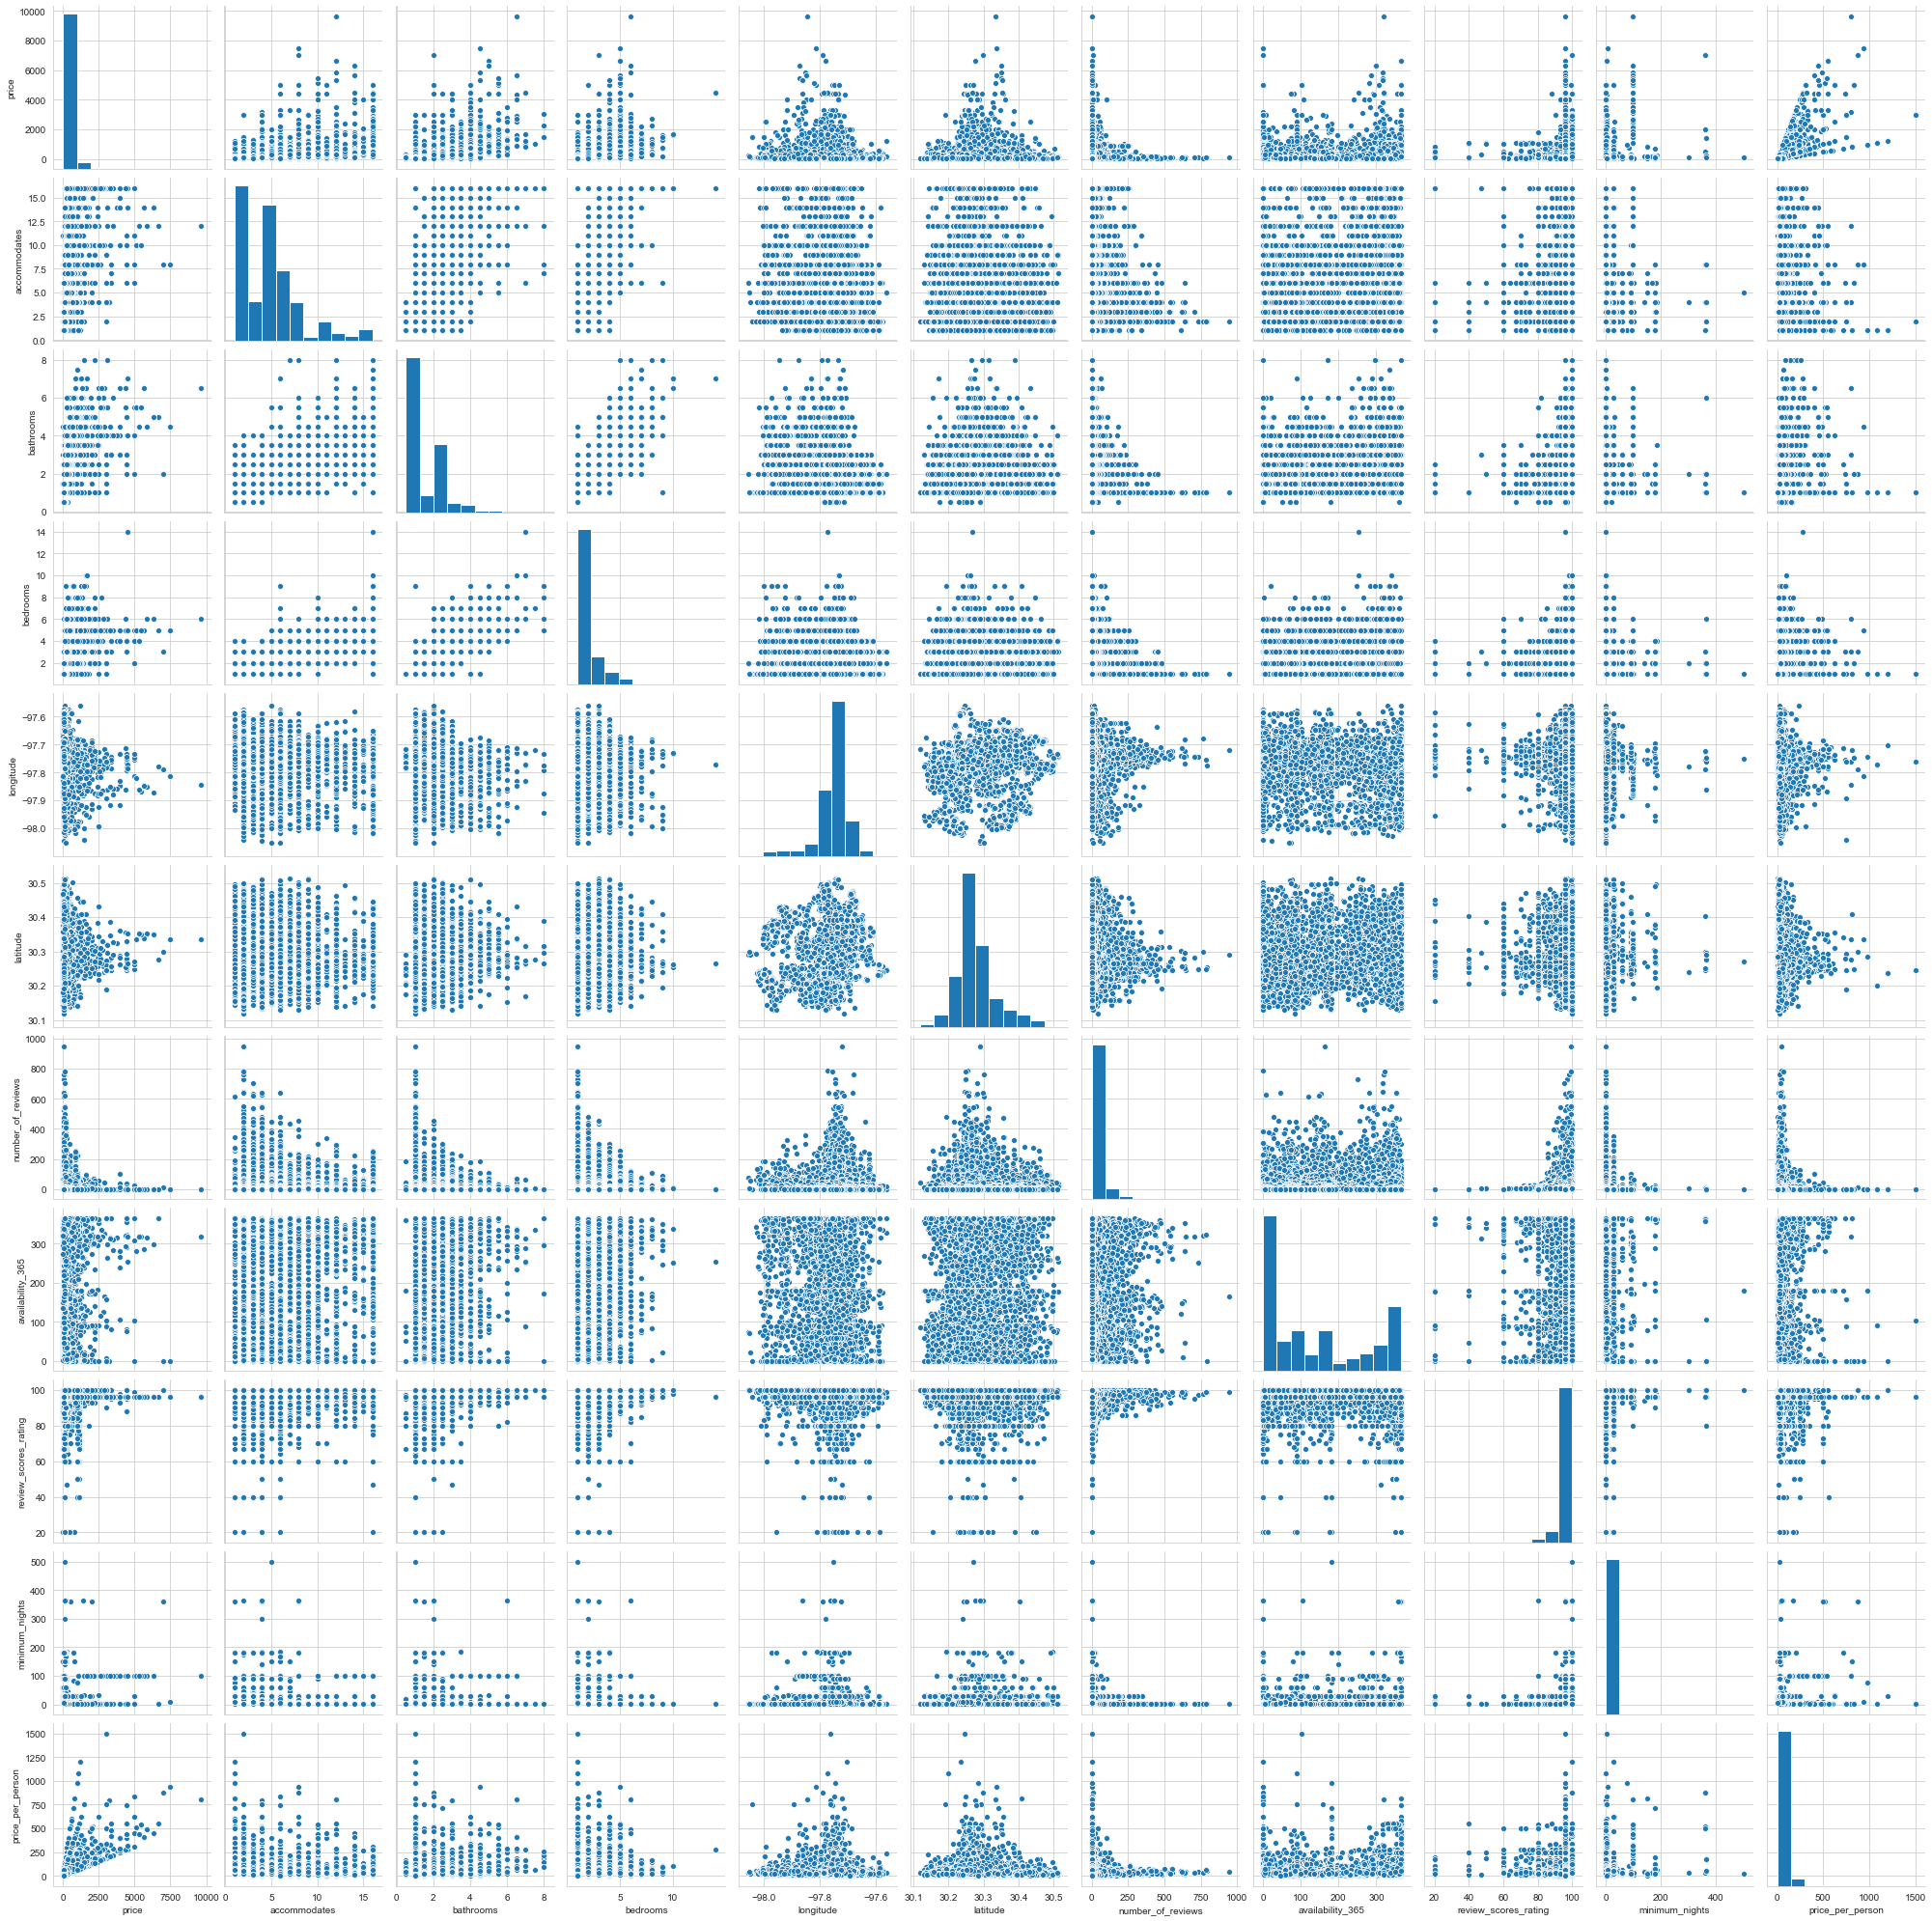

In [131]:
sns.pairplot(df)

In [132]:
#df.loc[19840835]['price']

In [133]:
df.groupby('property_type')['price'].size()

property_type
Aparthotel              23
Apartment             3104
Barn                     4
Bed and breakfast       31
Boat                     6
Boutique hotel          38
Bungalow               298
Bus                      2
Cabin                   17
Camper/RV               90
Campsite                 1
Chalet                   2
Condominium           1066
Cottage                 68
Dome house               3
Earth house              1
Farm stay                9
Guest suite            270
Guesthouse             538
Hostel                  25
Hotel                    3
House                 5078
Houseboat                3
Loft                   138
Nature lodge             1
Other                   39
Resort                  48
Serviced apartment     166
Tent                     9
Tiny house              64
Tipi                     3
Townhouse              415
Treehouse                5
Villa                   43
Yurt                     4
Name: price, dtype: int64

In [134]:
for pt in df['property_type']:
    unique_percent_counts = df['property_type'].value_counts()
    
    top_frequent_indexes = unique_percent_counts[:10-1].index.values.tolist()
    x = df['property_type'].copy()
    x[~x.isin(top_frequent_indexes)] = 'OTHER'
    
    df['property_type'] = x
df['property_type'].value_counts()

House                 5078
Apartment             3104
Condominium           1066
OTHER                  680
Guesthouse             538
Townhouse              415
Bungalow               298
Guest suite            270
Serviced apartment     166
Name: property_type, dtype: int64

In [135]:
#df = df[df['property_type'] != 'OTHER']

In [136]:
df['property_type'].value_counts()

House                 5078
Apartment             3104
Condominium           1066
OTHER                  680
Guesthouse             538
Townhouse              415
Bungalow               298
Guest suite            270
Serviced apartment     166
Name: property_type, dtype: int64

In [137]:
df.to_csv('data/listings_cleaned.csv')

In [138]:
df.isnull().sum()

property_type           0
room_type               0
price                   0
accommodates            0
bathrooms               0
bedrooms                0
host_is_superhost       0
longitude               0
latitude                0
number_of_reviews       0
availability_365        0
review_scores_rating    0
minimum_nights          0
listing_url             0
price_per_person        0
region                  0
dtype: int64

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11615 entries, 2265 to 42931550
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_type         11615 non-null  object 
 1   room_type             11615 non-null  object 
 2   price                 11615 non-null  float64
 3   accommodates          11615 non-null  int64  
 4   bathrooms             11615 non-null  float64
 5   bedrooms              11615 non-null  float64
 6   host_is_superhost     11615 non-null  object 
 7   longitude             11615 non-null  float64
 8   latitude              11615 non-null  float64
 9   number_of_reviews     11615 non-null  int64  
 10  availability_365      11615 non-null  int64  
 11  review_scores_rating  11615 non-null  float64
 12  minimum_nights        11615 non-null  int64  
 13  listing_url           11615 non-null  object 
 14  price_per_person      11615 non-null  float64
 15  region       

In [140]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('data/listings.csv', low_memory=False)
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1500.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    # Replacing all 0 values in bathrooms with 'NaN'
    df['bathrooms'].replace(0, np.nan, inplace=True)
    df['bathrooms'].fillna((df['accommodates']//2), inplace=True)
    
    df['bedrooms'].replace(0, np.nan, inplace=True)
    df['bedrooms'].fillna((df['accommodates']//2), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
#df, df_no_impute, df_zeros_impute = clean_listings_data('data/listings.csv')